In [1]:
from pathlib import Path
import os
import shutil
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [2]:
B_HIGH_LIMIT = 1.3

FIELD_FRACTION = 0.35

B_REM = 1.4

TESLAMAX_PATH = Path.home() / "code" / "TeslaMax"

TESLAMAX_MPH_DIR = TESLAMAX_PATH / "java"

TESLAMAX_FILENAME = "TeslaMax_Model"
TESLAMAX_FILE_EXT = "mph"

TESLAMAX_FILE_STR = str(TESLAMAX_MPH_DIR / (TESLAMAX_FILENAME + "." + TESLAMAX_FILE_EXT))

PLAYGROUND_DIR = "teslamax-play"

In [3]:
TESLAMAX_FILE_STR

'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\java\\TeslaMax_Model.mph'

In [4]:
os.chdir(TESLAMAX_PATH)

In [5]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

## Optimization using Scipy

In [6]:
def optimize_ramp(B_high,field_fraction,params,filename=None):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside PLAYGROUND_DIR.
    The COMSOL model file is saved as 'filename' (with '.mph' extension) in TESLAMAX_MPH_DIR, 
    if provided.
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0
    
    target_args = (B_high,B_low,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    tstamp = datetime.now().strftime("%Y%m%d%H%M%S")
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / tstamp  )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    if filename:
        shutil.copy(src=TESLAMAX_FILE_STR,
                    dst=str(TESLAMAX_MPH_DIR / (filename + "." + TESLAMAX_FILE_EXT)))
    
    return (tmm_g,cost_function)
    

In [7]:
import nemplot
from nemplot import nemplot_parameters

In [8]:
nemplot.set_dpi(600)
nemplot.set_figsize_cm(10)
nemplot.set_fontsize(12)
nemplot.set_latex_font("Times New Roman")

In [9]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [18]:
def plot_optimized_ramp_comparison_internal_magnet(B_high,field_fraction,params,H_reg,R_s,R_o):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation with and without the internal magnet. 
    
    Common parameters for the case with the magnet are read from 'params', 
    and regenerator height and external radii for both magnets are provided separately 
    for comparing different cases. This function calculates the parameters 
    for the case without magnet.
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    Save the corresponding COMSOL models.
    """

    params_no_magnet = params.copy()
    params_no_magnet["phi_C_II"] = 0
    params_no_magnet["phi_S_II"] = 0
    params_no_magnet["n_II"] = 0
    
    for p in [params,params_no_magnet]:
        
        p["H[m]"] = H_reg
        p["R_s"] = R_s
        p["R_o"] = R_o
        p["h_gap"] = p["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
        
        n_II = p["n_II"]
        n_IV = p["n_IV"]
            
        n = n_II + n_IV
        
        # expand parameters to include remanence magnitudes for each segment
        p.update(teslamax.expand_parameters_from_remanence_array(B_REM*np.ones(n), 
                                                        p, 
                                                        "B_rem"))
    
    params_str = "_B_%d_H_%d_Rs_%d_Ro_%d" %(B_high*1000,H_reg*1e3,R_s*1e3,R_o*1e3)
    
    tm_file_magnet = TESLAMAX_FILENAME + "_magnet" + params_str
    tmm_magnet, K_magnet = optimize_ramp(B_high,field_fraction,params,tm_file_magnet)
    
    tm_file_no_magnet = TESLAMAX_FILENAME + "_no_magnet" + params_str
    tmm_no_magnet, K_no_magnet = optimize_ramp(B_high,field_fraction,params_no_magnet,tm_file_no_magnet)
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    phi_vector_magnet, B_vector_magnet = tmm_magnet.get_profile_data()
    phi_vector_no_magnet, B_vector_no_magnet = tmm_no_magnet.get_profile_data()
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_magnet,B_vector_magnet,linewidth=lw,label="With magnet")
    profile_axes_g.plot(phi_vector_no_magnet,B_vector_no_magnet,linewidth=lw,label='No magnet')
    
    profile_axes_g.set_xlim(0,np.max(phi_vector_magnet))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_magnet),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    #profile_axes_g.set_yticks(np.arange(0,B_HIGH_LIMIT+0.2,0.2),minor=True)
    
    B_low = 0.0
    B_target_vector = teslamax.calculate_ramp_profile(phi_vector_magnet,B_high,B_low,field_fraction)
    profile_axes_g.plot(phi_vector_magnet,B_target_vector,'--',linewidth=lw,label="Target")
    
    profile_axes_g.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

    nemplot.save_figure(profile_fig_g,"profile_comparison_magnet" + params_str)
    
    return (tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet)


## Parameters for situation with and without internal magnet

To understand these parameters, check the notebook `Choosing the profile and dimensions.ipynb`.

In [19]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3, 
    "W[m]": 30e-3,
    "N_r[]": 8, 
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "phi_S_IV": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

### Testing 3 points for R_o = 40 mm

This value for the external radius of the internal magnet has been used as a typical estimative, to fit 8 regenerators of 30 mm of width into a gap of 20 mm and use about 85% of the gap (leaving space for the walls and other structural elements, such as screws).

We select three operating points from that curve and test the profiles, with and without the internal magnet

In [20]:
R_s = 120e-3
R_o = 40e-3

Value of K with magnet: 0.001807
Parameters:
{'R_i': 0.015, 'h_fc': 0.005, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_II': 45, 'phi_S_IV': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'H[m]': 0.019, 'R_s': 0.12, 'R_o': 0.04, 'h_gap': 0.022, 'B_rem_II_1': 1.3999999999999999, 'B_rem_II_2': 1.3999999999999999, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'R_g': 0.062, 'alpha_rem_II_1': 38.312680467799723, 'alpha_rem_II_2': 13.652625432191302, 'alpha_rem_IV_1': 9.4492625659314644, 'alpha_rem_IV_2': 24.782705644959382, 'alpha_rem_IV_3': 50.049644466087877, 'alpha_rem_IV_4': 106.25434203541568}
Value of K without magnet: 0.002860
Parameters:
{'R_i': 0.015, 'h_fc': 0.005, 'R_e': 0.3, 'n_II': 0, 'n_IV': 4, 'phi_C_II': 0, 'phi_S_II': 0, 'phi_S_IV': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'H[m]': 0.019, 'R_s': 0.12, 'R_o': 0

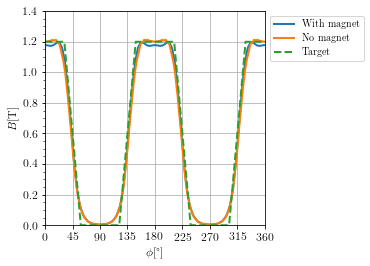

In [21]:
%matplotlib inline

B_max = 1.20
H_reg = 19e-3

tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet = plot_optimized_ramp_comparison_internal_magnet(B_max,
                                                                                                  FIELD_FRACTION,
                                                                                                  FIXED_PARAMETERS_MAGNET,
                                                                                                  H_reg,
                                                                                                  R_s,
                                                                                                  R_o)

print("Value of K with magnet: %.6f" %(K_magnet))
print("Parameters:")
print(tmm_magnet.params)
print("Value of K without magnet: %.6f" %(K_no_magnet))
print("Parameters:")
print(tmm_no_magnet.params)

Value of K with magnet: 0.001687
Parameters:
{'R_i': 0.015, 'h_fc': 0.005, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_II': 45, 'phi_S_IV': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'H[m]': 0.02, 'R_s': 0.12, 'R_o': 0.04, 'h_gap': 0.023, 'B_rem_II_1': 1.3999999999999999, 'B_rem_II_2': 1.3999999999999999, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'R_g': 0.063, 'alpha_rem_II_1': 20.276567040142645, 'alpha_rem_II_2': 7.3772227781708066, 'alpha_rem_IV_1': 4.7812716799604527, 'alpha_rem_IV_2': 14.794139193765481, 'alpha_rem_IV_3': 44.465992954521035, 'alpha_rem_IV_4': 99.649700079020633}
Value of K without magnet: 0.002869
Parameters:
{'R_i': 0.015, 'h_fc': 0.005, 'R_e': 0.3, 'n_II': 0, 'n_IV': 4, 'phi_C_II': 0, 'phi_S_II': 0, 'phi_S_IV': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'H[m]': 0.02, 'R_s': 0.12, 'R_o': 0.0

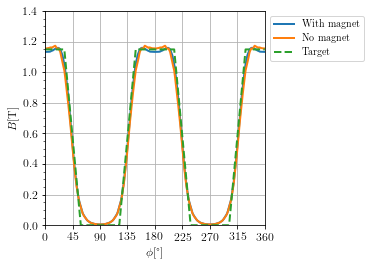

In [22]:
%matplotlib inline

B_max = 1.15
H_reg = 20e-3

tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet = plot_optimized_ramp_comparison_internal_magnet(B_max,
                                                                                                  FIELD_FRACTION,
                                                                                                  FIXED_PARAMETERS_MAGNET,
                                                                                                  H_reg,
                                                                                                  R_s,
                                                                                                  R_o)
print("Value of K with magnet: %.6f" %(K_magnet))
print("Parameters:")
print(tmm_magnet.params)
print("Value of K without magnet: %.6f" %(K_no_magnet))
print("Parameters:")
print(tmm_no_magnet.params)

Value of K with magnet: 0.001815
Parameters:
{'R_i': 0.015, 'h_fc': 0.005, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_II': 45, 'phi_S_IV': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'H[m]': 0.022, 'R_s': 0.12, 'R_o': 0.04, 'h_gap': 0.024999999999999998, 'B_rem_II_1': 1.3999999999999999, 'B_rem_II_2': 1.3999999999999999, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'R_g': 0.065, 'alpha_rem_II_1': 44.676214235967059, 'alpha_rem_II_2': 7.7877766034005118, 'alpha_rem_IV_1': 9.3774711579366627, 'alpha_rem_IV_2': 22.896535366773385, 'alpha_rem_IV_3': 48.537612189688623, 'alpha_rem_IV_4': 107.22514495120653}
Value of K without magnet: 0.002782
Parameters:
{'R_i': 0.015, 'h_fc': 0.005, 'R_e': 0.3, 'n_II': 0, 'n_IV': 4, 'phi_C_II': 0, 'phi_S_II': 0, 'phi_S_IV': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'H[m]': 0.022, 'R_s':

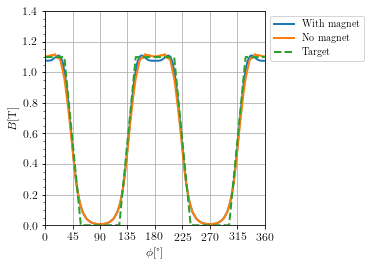

In [23]:
%matplotlib inline

B_max = 1.10
H_reg = 22e-3

tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet = plot_optimized_ramp_comparison_internal_magnet(B_max,
                                                                                                  FIELD_FRACTION,
                                                                                                  FIXED_PARAMETERS_MAGNET,
                                                                                                  H_reg,
                                                                                                  R_s,
                                                                                                  R_o)
print("Value of K with magnet: %.6f" %(K_magnet))
print("Parameters:")
print(tmm_magnet.params)
print("Value of K without magnet: %.6f" %(K_no_magnet))
print("Parameters:")
print(tmm_no_magnet.params)

### Testing smaller iron cylinders

## Larger magnets

In [26]:
B_HIGH_LIMIT = 1.6

In [24]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "N_r[]": 10,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_LARGE_MAGNET = {"R_i": 0.015,
                "R_o": 0.070,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "phi_S_IV": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

Value of K with magnet: 0.004114
Value of K without magnet: 0.005458


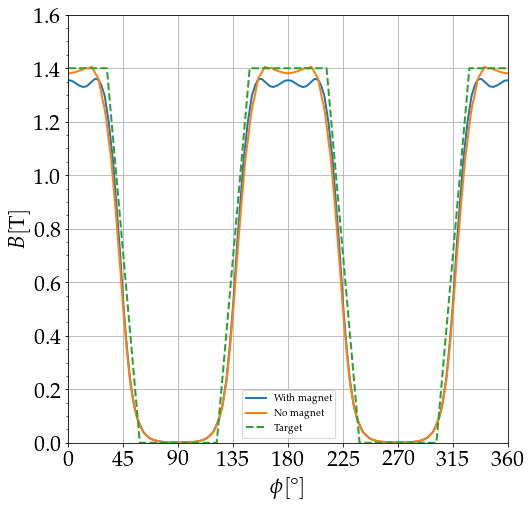

In [27]:
%matplotlib inline

B_max = 1.4
H_reg = 25e-3
R_s = 200e-3

tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet = plot_optimized_ramp_comparison_internal_magnet(B_max,
                                                                                                  FIELD_FRACTION,
                                                                                                  FIXED_PARAMETERS_LARGE_MAGNET,
                                                                                                  H_reg,
                                                                                                  R_s)

print("Value of K with magnet: %.6f" %(K_magnet))
print("Value of K without magnet: %.6f" %(K_no_magnet))

In [28]:
tmm_magnet.run()